In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#import cudf

from tqdm import tqdm

tqdm.pandas()

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/scan-classification-challange/sample_submission.csv
/kaggle/input/scan-classification-challange/df_train.csv
/kaggle/input/scan-classification-challange/df_test.csv


In [2]:
#%tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils

import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 613.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 17.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install -U pymorphy2-dicts-ru

Note: you may need to restart the kernel to use updated packages.


In [5]:
PATH = '/kaggle/input/scan-classification-challange/'

In [6]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [7]:
#посмотрим на трейн
train = pd.read_csv(PATH + 'df_train.csv')

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    60000 non-null  object
 1   class   60000 non-null  object
dtypes: object(2)
memory usage: 937.6+ KB


In [9]:
#посмотрим на количество классов
train['class'].nunique()

50

In [10]:
#посмотрим на сами классы и их распределение
train['class'].value_counts()

O                                                   40159
Теракт                                               1898
Взятки                                               1801
Экстремизм                                           1798
Уголовное обвинение                                  1634
Пожары                                               1510
Привлечение к уголовной ответственности              1475
Землетрясение                                         841
Утечка нефти                                          816
Противодействие коррупции                             707
Поддержка террористов                                 702
Заключение под стражу                                 694
Нарушение закона                                      636
Коррупция                                             599
Уголовное задержание                                  517
Наводнение                                            489
Кораблекрушение                                       378
Авиакатастрофа

<AxesSubplot:>

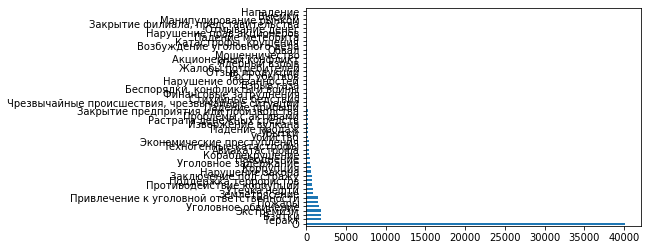

In [11]:
train['class'].value_counts().plot(kind = 'barh')

Распределение неравномерное. Доминирование класса "О". Мне кажется, что при автоматической разметке, этот класс присваивался текстам, которые не смогли определить к какому-нибудь классу. 
Эту неравномерность нужно будет учитывать при разделении на трейн и тест.

In [12]:
#посмотрим несколко примеров
train.sample(3)

,text,class
20048,Эксперт поясняет – в тот момент девелоперы про...,O
30419,Агентством РК по противодействию коррупции изо...,O
8788,"Это подтвердили приглашенные в суд свидетели"",...",O


In [13]:
train['text'].iloc[44556]

'И этому есть весомые причины, ведь авиакатострофы хоть и случаются нечасто, зато о них пишут и говорят в разы больше, чем об автоавариях, железнодорожных и кораблекрушениях.'

In [14]:
train['class'].iloc[44556]

'Кораблекрушение'

Как видно из примера выше, разметка не совсем корректная. Но:
1. судя по всему тест размечен таким же образом, поэтому и корректировать классы будет не правильно;
2. количество размеченных новостей, почти 20 тысяч, поэтому перебирать их нецелесообразно с точки зрения затраченного времени. 

### Подгoтовлю текст - переведу в нижний регистр, удалю пунктуацию, цифры и стоп-слова

In [15]:
import string
spec_chars = string.punctuation + '«'+ '»'+ '—'+ '"'+ '"'
print(spec_chars)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~«»—""


In [16]:
def rem_spec_chars(x):
    x = "".join([ch for ch in x if ch not in spec_chars])
    x = "".join([x.replace('\d+', '')])
    return x

In [17]:
train['text_lem'] = train['text'].progress_apply(rem_spec_chars)

100%|██████████| 60000/60000 [00:01<00:00, 40920.81it/s]


In [18]:
def low(x):
  x = list(x.split())
  x = [w.lower() for w in x]
  return x

In [19]:
train['text_lem'] = train['text_lem'].progress_apply(low)

100%|██████████| 60000/60000 [00:00<00:00, 76294.47it/s]


In [20]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [21]:
from nltk.corpus import stopwords
russian_stopwords = stopwords.words("russian")

In [22]:
russian_stopwords.extend(['это', 'ктото'])

In [23]:
def stop_words(x):
  new_x = []
  for w in x:
    if w not in russian_stopwords:
        new_x.append(w)
  return new_x

In [24]:
train['text_lem'] = train['text_lem'].progress_apply(stop_words)

100%|██████████| 60000/60000 [00:02<00:00, 20421.07it/s]


In [25]:
train.sample(3)

,text,class,text_lem
9293,Министр культуры и спорта РК Актоты Раимкулова...,O,"[министр, культуры, спорта, рк, актоты, раимку..."
42690,Он приговорен к пожизненному заключению.,Привлечение к уголовной ответственности,"[приговорен, пожизненному, заключению]"
31463,"Вместе с тем Павел Корчагин, финансовый управл...",O,"[вместе, павел, корчагин, финансовый, управляю..."


### Лемматизирую текст

In [26]:
import pymorphy2 

In [27]:
morph = pymorphy2.MorphAnalyzer()

In [28]:
def lem(x):
    #x = list(x.split())
    x = [morph.parse(w)[0].normal_form for w in x]
    return x

In [29]:
#train_cuda = cudf.DataFrame(train)

In [30]:
train['text_lem'] = train['text_lem'].progress_apply(lem)

100%|██████████| 60000/60000 [03:55<00:00, 254.74it/s]


In [31]:
train.sample(3)

,text,class,text_lem
45650,"Федеральный закон ""О противодействии экстремис...",Экстремизм,"[федеральный, закон, противодействие, экстреми..."
7551,Предприниматель заявлял о конфликте с местными...,O,"[предприниматель, заявлять, конфликт, местный,..."
23311,"""Точной даты пока нет"", - сказал представитель...",O,"[точный, дата, пока, сказать, представитель, к..."


In [32]:
#%time
#train_cuda['text_lem'] = train['text'].apply(lem)

In [33]:
unique_words = {}
for i in tqdm(train.index):
    for j in set(train['text_lem'].loc[i]):
        if len(j) == 1:
            pass
        else:
            if j in unique_words.keys():
                unique_words[j] += 1
            else:
                unique_words[j] = 1

100%|██████████| 60000/60000 [00:02<00:00, 29015.14it/s]


In [34]:
#unique_words = {}
#for i in tqdm(train_cuda.index):
#    for j in set(train_cuda['text_lem'].loc[i]):
#        if j in unique_words.keys():
#            unique_words[j] += 1
#        else:
#            unique_words[j] = 1

In [35]:
sorted(list(unique_words.values()), reverse = True)[5000]

19

In [36]:
#train = pd.DataFrame(train_cuda)

In [37]:
pop_words = []
for i in tqdm(unique_words.keys()):
    if unique_words[i] < 4:
        pass
    else:
        pop_words.append(i)

100%|██████████| 52938/52938 [00:00<00:00, 1169206.00it/s]


In [38]:
pop_words

['должный',
 'лично',
 'кудрин',
 'нацпроект',
 'продолжать',
 'он',
 'например',
 'цель',
 'вестись',
 'работа',
 'уверенный',
 'обязать',
 'задача',
 'другой',
 'сотрудник',
 'взгляд',
 'пользование',
 'хранить',
 '1го',
 'служебный',
 'поездка',
 'секретно',
 'анкета',
 'отдел',
 'специальный',
 'допуск',
 'информация',
 'политический',
 'документ',
 'работник',
 'гриф',
 'отмечать',
 'граница',
 'сирийский',
 'это',
 'отметить',
 'необходимо',
 'пока',
 'активный',
 'мера',
 'служба',
 'принимать',
 'справляться',
 'безопасность',
 'тело',
 'жертва',
 'днк',
 'совпасть',
 'сообщить',
 'найти',
 'мужчина',
 'образец',
 'мвд',
 'джена',
 'пресссекретарить',
 'дом',
 'среда',
 'регулярный',
 'брифинг',
 'журналист',
 'псак',
 'белый',
 'обжаловать',
 'добавить',
 'быть',
 'приговор',
 'верхнекамский',
 'район',
 'милицейский',
 'произойти',
 'пожар',
 'автомобиль',
 'кирс',
 'ул',
 'госдума',
 'брат',
 'арестовать',
 'кража',
 'новость',
 'фото',
 'прокомментировать',
 'уралинформбюро

In [39]:
def text_lem_set(x):
    y = []
    for w in x:
        if w in pop_words:
            y.append(w)
        else:
            pass
    return y          
            

In [40]:
train['text_lem_set'] = train['text_lem'].progress_apply(lambda x: text_lem_set(x))

100%|██████████| 60000/60000 [01:32<00:00, 648.81it/s]


In [41]:
train.sample()

,text,class,text_lem,text_lem_set
44037,"По словам Дмитрия Медянцева, работы по общим з...",O,"[слово, дмитрий, медянцев, работа, общий, заме...","[слово, дмитрий, работа, общий, наземный, съём..."


In [42]:
train['text_lem_set_len'] = train['text_lem_set'].apply(lambda x: len(x))

<AxesSubplot:>

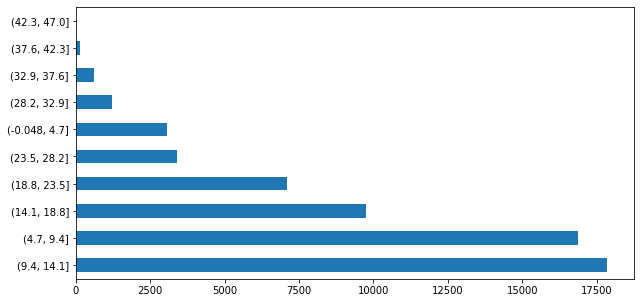

In [43]:
train['text_lem_set_len'].value_counts(bins = 10).plot(kind = 'barh',figsize = (10, 5))

In [44]:
len(pop_words)

15260

Количество уникальных слов 162 000 \
Лемматизированных уникальных слов 109 627

##  Попробую пойти по пути токенизации текста и моделей TesorFlow

In [45]:
# Максимальное количество слов 
num_words = len(pop_words)
# Максимальная длина новости
max_news_len = 29
# Количество классов новостей
nb_classes = 50

In [46]:
train['class'] = train['class'].astype('category')
train['class_cat'] = train['class'].cat.codes
train.sample(3)

,text,class,text_lem,text_lem_set,text_lem_set_len,class_cat
48627,Охотминимум включает в себя знание правил охот...,O,"[охотминимум, включать, знание, правило, охота...","[включать, знание, правило, охота, требование,...",12,0
43136,"Землетрясение магнитудой 3,1 произошло у села ...",Землетрясение,"[землетрясение, магнитуда, 31, произойти, село...","[землетрясение, магнитуда, 31, произойти, село...",22,12
43775,Об этом заявили в Генпрокуратуре самопровозгла...,O,"[заявить, генпрокуратура, самопровозглашённый,...","[заявить, генпрокуратура, самопровозглашённый,...",4,0


In [47]:
X = train['text_lem_set']
y = train['class']

In [48]:
y = pd.get_dummies(y)

In [49]:
y.sample()

,O,Авиакатастрофа,Акционерный конфликт,"Беспорядки, конфликты и войны",Взрыв газа,Взятки,Возбуждение уголовного дела,Выемки,Жалобы потребителей,Заключение под стражу,...,Убийство,Убытки,Уголовное задержание,Уголовное обвинение,Утечка нефти,Финансовые затруднения,"Чрезвычайные происшествия, чрезвычайные ситуации",Экономические преступления,Экстремизм,Ядерный взрыв
47265,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
#разделяем на трейн и тест с учётом неравномернойти классов

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.2)

In [51]:
X_train

40360    [сотрудник, задержать, куликов, кабинет, здани...
2442               [вывод, прокурор, вполне, закономерный]
44260    [количество, жертва, землетрясение, возле, бер...
20575    [арестовать, 1989, год, приговорить, пожизненн...
41569                                [мельник, нормальный]
                               ...                        
37816    [олег, орлов, уголовный, ответственность, этот...
53792    [украинский, спецслужба, экстремистский, орган...
59665    [мнение, левин, оказаться, выгодный, губернато...
21417    [также, прокомментировать, ситуация, вызвать, ...
20373    [мошенничество, зачастую, преступление, потерп...
Name: text_lem_set, Length: 48000, dtype: object

Преобразую номера классов в кагориальную матрицу 

In [52]:
y_train

,O,Авиакатастрофа,Акционерный конфликт,"Беспорядки, конфликты и войны",Взрыв газа,Взятки,Возбуждение уголовного дела,Выемки,Жалобы потребителей,Заключение под стражу,...,Убийство,Убытки,Уголовное задержание,Уголовное обвинение,Утечка нефти,Финансовые затруднения,"Чрезвычайные происшествия, чрезвычайные ситуации",Экономические преступления,Экстремизм,Ядерный взрыв
40360,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2442,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44260,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20575,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41569,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37816,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53792,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
59665,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21417,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
y_train = np.array(y_train)

In [54]:
y_train

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]], dtype=uint8)

In [55]:
y_test = np.array(y_test)

In [56]:
y_test

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [57]:
tokenizer = Tokenizer(num_words=num_words)

In [58]:
tokenizer.fit_on_texts(train['text_lem_set'])

In [59]:
train_sequences = tokenizer.texts_to_sequences(X_train)

x_train = pad_sequences(train_sequences, maxlen=max_news_len)

test_sequences = tokenizer.texts_to_sequences(X_test)

x_test = pad_sequences(test_sequences, maxlen=max_news_len)

## Сверточная нейронная сеть

In [60]:
model_cnn = Sequential()
model_cnn.add(Embedding(num_words, 32, input_length=max_news_len))
model_cnn.add(Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(50, activation='softmax'))

2022-08-03 18:37:27.611737: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [61]:
model_cnn.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [62]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 29, 32)            488320    
_________________________________________________________________
conv1d (Conv1D)              (None, 25, 250)           40250     
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32128     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                6450      
Total params: 567,148
Trainable params: 567,148
Non-trainable params: 0
_________________________________________________________________


In [63]:
model_cnn_save_path = './model_weights/best_model_cnn.h5'
checkpoint_callback_cnn = ModelCheckpoint(model_cnn_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [64]:
history_cnn = model_cnn.fit(x_train, 
                            y_train, 
                            epochs=5,
                            batch_size=128,
                            validation_split=0.01,
                            callbacks=[checkpoint_callback_cnn])
                            #use_multiprocessing=True)

2022-08-03 18:37:30.418549: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
372/372 [==============================] - 11s 27ms/step - loss: 1.4132 - accuracy: 0.6974 - val_loss: 0.8875 - val_accuracy: 0.7875

Epoch 00001: val_accuracy improved from -inf to 0.78750, saving model to ./model_weights/best_model_cnn.h5
Epoch 2/5
372/372 [==============================] - 10s 27ms/step - loss: 0.6010 - accuracy: 0.8460 - val_loss: 0.4832 - val_accuracy: 0.8938

Epoch 00002: val_accuracy improved from 0.78750 to 0.89375, saving model to ./model_weights/best_model_cnn.h5
Epoch 3/5
372/372 [==============================] - 11s 30ms/step - loss: 0.3384 - accuracy: 0.9063 - val_loss: 0.3985 - val_accuracy: 0.9062

Epoch 00003: val_accuracy improved from 0.89375 to 0.90625, saving model to ./model_weights/best_model_cnn.h5
Epoch 4/5
372/372 [==============================] - 10s 27ms/step - loss: 0.2298 - accuracy: 0.9318 - val_loss: 0.3914 - val_accuracy: 0.9187

Epoch 00004: val_accuracy improved from 0.90625 to 0.91875, saving model to ./model_weights/best_

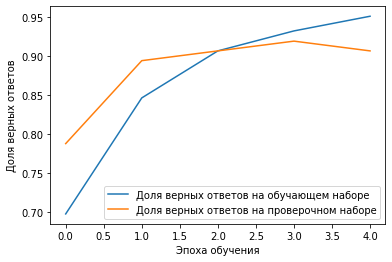

In [65]:
plt.plot(history_cnn.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_cnn.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Cеть LSTM

In [66]:
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, 32, input_length=max_news_len))
model_lstm.add(LSTM(16))
model_lstm.add(Dense(50, activation='softmax'))

In [67]:
model_lstm.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [68]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 29, 32)            488320    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                3136      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                850       
Total params: 492,306
Trainable params: 492,306
Non-trainable params: 0
_________________________________________________________________


In [69]:
model_lstm_save_path = './model_weights/best_model_lstm.h5'
checkpoint_callback_lstm = ModelCheckpoint(model_lstm_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [70]:
history_lstm = model_lstm.fit(x_train, 
                              y_train, 
                              epochs=6,
                              batch_size=128,
                              validation_split=0.01,
                              callbacks=[checkpoint_callback_lstm],
                              use_multiprocessing=True)

Epoch 1/6
372/372 [==============================] - 17s 39ms/step - loss: 1.9382 - accuracy: 0.6631 - val_loss: 1.3243 - val_accuracy: 0.6979

Epoch 00001: val_accuracy improved from -inf to 0.69792, saving model to ./model_weights/best_model_lstm.h5
Epoch 2/6
372/372 [==============================] - 15s 40ms/step - loss: 1.2323 - accuracy: 0.6835 - val_loss: 1.0917 - val_accuracy: 0.7250

Epoch 00002: val_accuracy improved from 0.69792 to 0.72500, saving model to ./model_weights/best_model_lstm.h5
Epoch 3/6
372/372 [==============================] - 14s 37ms/step - loss: 1.0030 - accuracy: 0.7555 - val_loss: 0.9507 - val_accuracy: 0.7688

Epoch 00003: val_accuracy improved from 0.72500 to 0.76875, saving model to ./model_weights/best_model_lstm.h5
Epoch 4/6
372/372 [==============================] - 14s 37ms/step - loss: 0.7976 - accuracy: 0.8028 - val_loss: 0.8172 - val_accuracy: 0.8042

Epoch 00004: val_accuracy improved from 0.76875 to 0.80417, saving model to ./model_weights/be

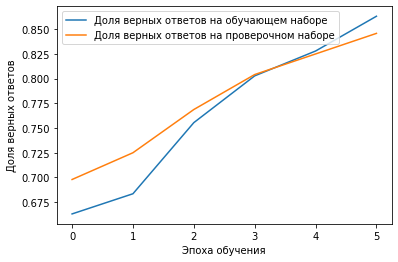

In [71]:
plt.plot(history_lstm.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_lstm.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Cеть GRU

In [72]:
model_gru = Sequential()
model_gru.add(Embedding(num_words, 32, input_length=max_news_len))
model_gru.add(GRU(16))
model_gru.add(Dense(50, activation='softmax'))

In [73]:
model_gru.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [74]:
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 29, 32)            488320    
_________________________________________________________________
gru (GRU)                    (None, 16)                2400      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                850       
Total params: 491,570
Trainable params: 491,570
Non-trainable params: 0
_________________________________________________________________


In [75]:
model_gru_save_path = './model_weights/best_model_gru.h5'
checkpoint_callback_gru = ModelCheckpoint(model_gru_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [76]:
history_gru = model_gru.fit(x_train, 
                              y_train, 
                              epochs=6,
                              batch_size=128,
                              validation_split=0.01,
                              callbacks=[checkpoint_callback_gru],
                              use_multiprocessing=True)

Epoch 1/6
372/372 [==============================] - 20s 46ms/step - loss: 1.8897 - accuracy: 0.6632 - val_loss: 1.2713 - val_accuracy: 0.7000

Epoch 00001: val_accuracy improved from -inf to 0.70000, saving model to ./model_weights/best_model_gru.h5
Epoch 2/6
372/372 [==============================] - 17s 45ms/step - loss: 1.1730 - accuracy: 0.7219 - val_loss: 0.9199 - val_accuracy: 0.7979

Epoch 00002: val_accuracy improved from 0.70000 to 0.79792, saving model to ./model_weights/best_model_gru.h5
Epoch 3/6
372/372 [==============================] - 16s 44ms/step - loss: 0.8022 - accuracy: 0.8134 - val_loss: 0.6988 - val_accuracy: 0.8375

Epoch 00003: val_accuracy improved from 0.79792 to 0.83750, saving model to ./model_weights/best_model_gru.h5
Epoch 4/6
372/372 [==============================] - 17s 47ms/step - loss: 0.6075 - accuracy: 0.8531 - val_loss: 0.6028 - val_accuracy: 0.8625

Epoch 00004: val_accuracy improved from 0.83750 to 0.86250, saving model to ./model_weights/best_

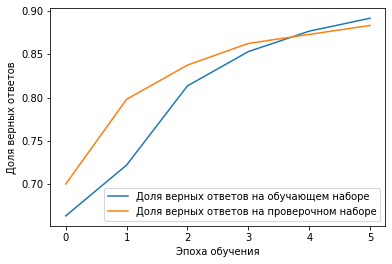

In [77]:
plt.plot(history_gru.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_gru.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Оцениваем качество работы сети на тестовом наборе данных

### Одномерная сверточная сеть 

In [78]:
model_cnn.load_weights(model_cnn_save_path)

In [79]:
model_cnn.evaluate(x_test, y_test, verbose=1)

375/375 [==============================] - 2s 5ms/step - loss: 0.4058 - accuracy: 0.8873


[0.4057527184486389, 0.887333333492279]

### Сеть LSTM

In [80]:
model_lstm.load_weights(model_lstm_save_path)

In [81]:
model_lstm.evaluate(x_test, y_test, verbose=1)

375/375 [==============================] - 4s 8ms/step - loss: 0.6406 - accuracy: 0.8412


[0.6405897736549377, 0.8411666750907898]

### Сеть GRU

In [82]:
model_gru.load_weights(model_gru_save_path)

In [83]:
model_gru.evaluate(x_test, y_test, verbose=1)

375/375 [==============================] - 5s 12ms/step - loss: 0.5289 - accuracy: 0.8684


[0.5288543105125427, 0.8684166669845581]

# Загружу тестовые данные и получу предсказание

In [84]:
test = pd.read_csv(PATH + 'df_test.csv')
test.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [85]:
test.sample(3)

,text,class
19858,"Личной выгоды никакой не было"", – сказал тогда...",O
29682,"Я хочу, чтобы процесс пошел дальше"", - сказала...",O
9580,"""В республику на развитие детского футбола еже...",O


In [86]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   class   40000 non-null  object
dtypes: object(2)
memory usage: 625.1+ KB


In [87]:
test['text_lem'] = test['text'].progress_apply(rem_spec_chars)

100%|██████████| 40000/40000 [00:00<00:00, 41531.10it/s]


In [88]:
test['text_lem'] = test['text_lem'].progress_apply(low)

100%|██████████| 40000/40000 [00:00<00:00, 84251.39it/s]


In [89]:
test['text_lem'] = test['text_lem'].progress_apply(stop_words)

100%|██████████| 40000/40000 [00:02<00:00, 15201.07it/s]


In [90]:
test['text_lem'] = test['text_lem'].progress_apply(lem)

100%|██████████| 40000/40000 [02:31<00:00, 264.70it/s]


In [91]:
test['text_lem_set'] = test['text_lem'].progress_apply(lambda x: text_lem_set(x))

100%|██████████| 40000/40000 [01:07<00:00, 588.71it/s]


In [92]:
test_2_sequences = tokenizer.texts_to_sequences(test['text_lem_set'])

x_test_2 = pad_sequences(test_2_sequences, maxlen=max_news_len)

In [93]:
y_test_pred_cnn = model_cnn.predict(x_test_2, verbose=1)
#y_test_pred_lstm = model_lstm.predict(x_test_2, verbose=1)
y_test_pred_gru = model_gru.predict(x_test_2, verbose=1)

1250/1250 [==============================] - 15s 11ms/step


In [94]:
test_pred = np.zeros(y_test_pred_cnn.shape)
for i in tqdm(range(y_test_pred_cnn.shape[0])):
    for j in range(y_test_pred_cnn.shape[1]):
        test_pred[i,j] = max(y_test_pred_cnn[i,j], y_test_pred_gru[i,j])

test_pred.shape


100%|██████████| 40000/40000 [00:02<00:00, 19284.18it/s]


(40000, 50)

In [95]:
test_pred[1].max()

0.9552508592605591

In [96]:
test.sample(3)

,text,class,text_lem,text_lem_set
12099,Из разряда невозможного: дело против многодетн...,O,"[разряд, невозможный, дело, против, многодетны...","[невозможный, дело, против, многодетный, мать,..."
23103,"Но очевидцы рассказывают, что по лондонским ма...",O,"[очевидец, рассказывать, лондонский, магазин, ...","[очевидец, рассказывать, лондонский, магазин, ..."
6572,В отношении начальника ГИБДД Ставрополья возбу...,O,"[отношение, начальник, гибдд, ставрополье, воз...","[отношение, начальник, гибдд, ставрополье, воз..."


In [97]:
test_pred_class = []
for i in range(len(test_pred)):
    index, max_value = max(enumerate(test_pred[i]), key=lambda i_v: i_v[1])
    test_pred_class.append((index))

In [98]:
test_pred_class[0], len(test_pred_class)

(0, 40000)

In [99]:
test['class_cat'] = 0

In [100]:
y.columns[0]

'O'

In [101]:
for i in tqdm(test.index):
    test['class_cat'].iloc[i] = test_pred_class[i]

  0%|          | 0/40000 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
100%|██████████| 40000/40000 [00:15<00:00, 2654.65it/s]


In [102]:
test['class'] = test['class_cat'].apply(lambda x: y.columns[x])

In [103]:
test.sample(3)

,text,class,text_lem,text_lem_set,class_cat
6722,"Он выяснил, что Ситников якобы заплатил за сво...",O,"[выяснить, ситниковый, якобы, заплатить, свобо...","[выяснить, ситниковый, якобы, заплатить, свобо...",0
37301,"Ранее глава Крыма Сергей Аксенов сообщил, что ...",O,"[ранее, глава, крым, сергей, аксёнов, сообщить...","[ранее, глава, крым, сергей, аксёнов, сообщить...",0
10215,"По словам ""донецких"", российские кураторы ФСБ ...",O,"[слово, донецкий, российский, куратор, фсб, дн...","[слово, донецкий, российский, куратор, фсб, дн...",0


In [104]:
test['class'].value_counts()

O                                                   27510
Теракт                                               1403
Взятки                                               1357
Экстремизм                                           1336
Уголовное обвинение                                  1147
Пожары                                               1010
Привлечение к уголовной ответственности               991
Землетрясение                                         638
Утечка нефти                                          564
Противодействие коррупции                             470
Поддержка террористов                                 470
Заключение под стражу                                 432
Коррупция                                             377
Наводнение                                            353
Кораблекрушение                                       260
Уголовное задержание                                  241
Нарушение закона                                      233
Авиакатастрофа

In [105]:
sub = pd.read_csv(PATH + 'sample_submission.csv')

In [106]:
sub.sample(5)

,id,class
958,958,O
16486,16486,O
36542,36542,O
5026,5026,O
16763,16763,O


In [107]:
submission = pd.DataFrame({'id':test.index})

In [108]:
submission['class'] = test['class']

In [109]:
submission.sample(3)

,id,class
15691,15691,O
16122,16122,O
37323,37323,Кораблекрушение


In [110]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      40000 non-null  int64 
 1   class   40000 non-null  object
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [111]:
#!pip install pandas==1.3.5

In [112]:
submission.to_csv('./submission.csv', index=False)